# Exercise 03: CLIP zero-shot prediction
In this exercise, you will perform zero-shot prediction using CLIP.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10
from torchvision import datasets
from torchvision import transforms
import torchvision

from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from PIL import Image

import sys 
sys.path.append("..")
from clip import clip

from sklearn.metrics import confusion_matrix
import seaborn as sns


### Hyperparameters

In [2]:
# # random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128

# CLIP
VISUAL_BACKBONE = 'ViT-B/16' 


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



### Dataset


In [4]:
transform_mnist_test = transforms.Compose([
    transforms.Resize(size=224),
    transforms.CenterCrop(size=(224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_set = torchvision.datasets.MNIST(root='/shareddata', train=False,
                                      download=True, transform=transform_mnist_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                              shuffle=False, num_workers=128)

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
dataset_name = 'MNIST'


### Model

In [5]:
# Load the model
model, preprocess = clip.load(name=VISUAL_BACKBONE, device=device, download_root='/shareddata/clip/')
model.to(device)


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

### Task 1: Prompt Gereration
---

Please denfine a function named ``prompt_encode`` to encode the text using CLIP text encoder.


In [6]:
prompt = '' 

def prompt_encode(prompt):
    
    text_inputs = torch.cat([clip.tokenize(f"{prompt} {c}") for c in class_names]).to(device)
 
    return text_inputs


### Task 2: Zero-shot inference
---

Please denfine a function named ``model_inference``. The function is essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Encode the image.
2. Encode the text.
3. Calculate the logits.

In [7]:
def model_inference(model, images, text_inputs):

    image_features = model.encode_image(images)
    text_features = model.encode_text(text_inputs)
    
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
    logit_scale = model.logit_scale.exp()
    
    similarity = logit_scale * image_features @ text_features.t()

    return similarity


### Task 3: Zero-shot accuracy calculation
---

Batch 10/79
Batch 20/79
Batch 30/79
Batch 40/79
Batch 50/79
Batch 60/79
Batch 70/79


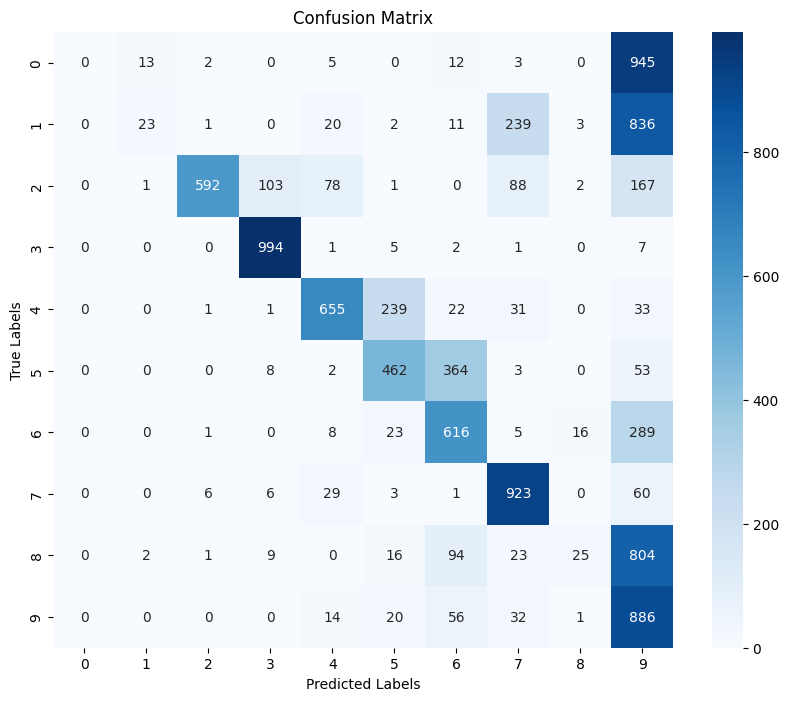

The zero-shot performance on MNIST is 51.81%, visual encoder is ViT-B/16.
The average testing loss is 1.5914.


In [8]:
#正确lable,无其他文本
prompt=''
testing_loss = []
testing_acc = []

with torch.no_grad():
    model.eval()
    all_predictions = []
    all_labels = []
    
    for batch_idx, (images, labels) in enumerate(test_dataloader, start=1):
        images = images.to(device)
        labels = labels.to(device)
        
        text_inputs = prompt_encode(prompt)

        similarity = model_inference(model, images, text_inputs)
        
        criterion_CE = nn.CrossEntropyLoss()
        
        loss = criterion_CE(similarity, labels)
        testing_loss.append(loss.item())
        
        predictions = torch.argmax(similarity, dim=-1)
        acc = (predictions == labels).float().mean()
        testing_acc.append(acc.item())
        
        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}/{len(test_dataloader)}")
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())   

    val_loss = np.mean(testing_loss)
    val_acc = np.mean(testing_acc)  
    
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(f"The zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")
print(f"The average testing loss is {val_loss:.4f}.")

Batch 10/79
Batch 20/79
Batch 30/79
Batch 40/79
Batch 50/79
Batch 60/79
Batch 70/79


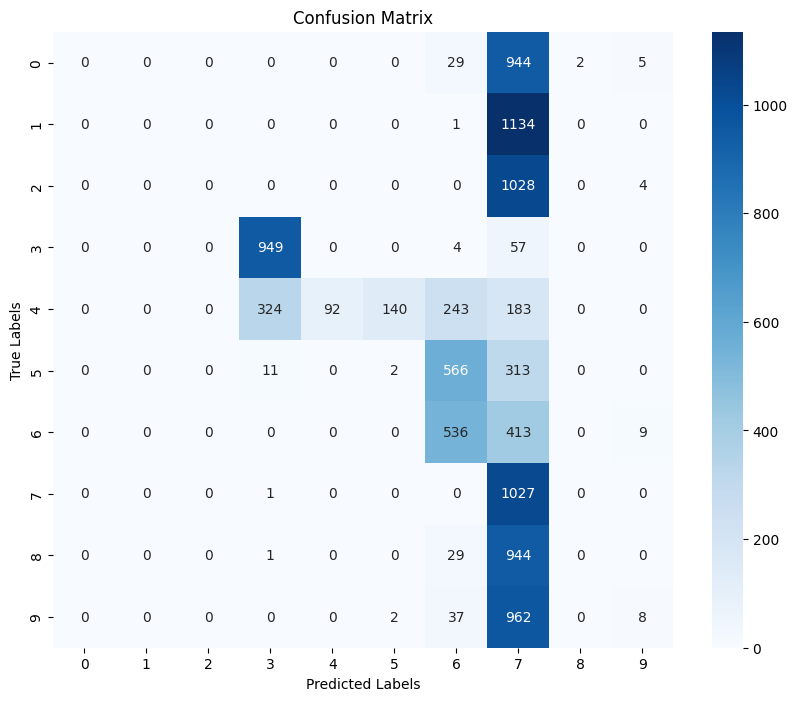

The zero-shot performance on MNIST is 26.20%, visual encoder is ViT-B/16.
The average testing loss is 2.1445.


In [9]:
prompt='asklhafhewufjkfhtjdy'

testing_loss = []
testing_acc = []

with torch.no_grad():
    model.eval()
    all_predictions = []
    all_labels = []
    
    for batch_idx, (images, labels) in enumerate(test_dataloader, start=1):
        images = images.to(device)
        labels = labels.to(device)
        
        text_inputs = prompt_encode(prompt)

        similarity = model_inference(model, images, text_inputs)
        
        criterion_CE = nn.CrossEntropyLoss()
        
        loss = criterion_CE(similarity, labels)
        testing_loss.append(loss.item())
        
        predictions = torch.argmax(similarity, dim=-1)
        acc = (predictions == labels).float().mean()
        testing_acc.append(acc.item())
        
        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}/{len(test_dataloader)}")
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())   

    val_loss = np.mean(testing_loss)
    val_acc = np.mean(testing_acc)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(f"The zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")
print(f"The average testing loss is {val_loss:.4f}.")

Batch 10/79
Batch 20/79
Batch 30/79
Batch 40/79
Batch 50/79
Batch 60/79
Batch 70/79


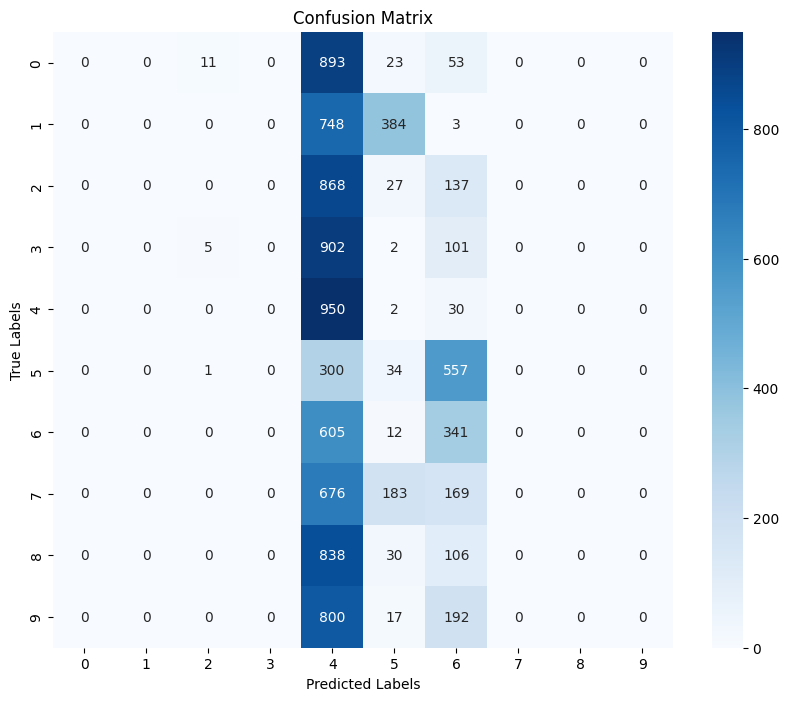

The zero-shot performance on MNIST is 13.24%, visual encoder is ViT-B/16.
The average testing loss is 2.3003.


In [10]:
prompt='0 1 2 3 4 5 6 7 8 9'

testing_loss = []
testing_acc = []

with torch.no_grad():
    model.eval()
    all_predictions = []
    all_labels = []
    
    for batch_idx, (images, labels) in enumerate(test_dataloader, start=1):
        images = images.to(device)
        labels = labels.to(device)
        
        text_inputs = prompt_encode(prompt)

        similarity = model_inference(model, images, text_inputs)
        
        criterion_CE = nn.CrossEntropyLoss()
        
        loss = criterion_CE(similarity, labels)
        testing_loss.append(loss.item())
        
        predictions = torch.argmax(similarity, dim=-1)
        acc = (predictions == labels).float().mean()
        testing_acc.append(acc.item())
        
        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}/{len(test_dataloader)}")
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())   

    val_loss = np.mean(testing_loss)
    val_acc = np.mean(testing_acc)   
    
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(f"The zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")
print(f"The average testing loss is {val_loss:.4f}.")

Batch 10/79
Batch 20/79
Batch 30/79
Batch 40/79
Batch 50/79
Batch 60/79
Batch 70/79


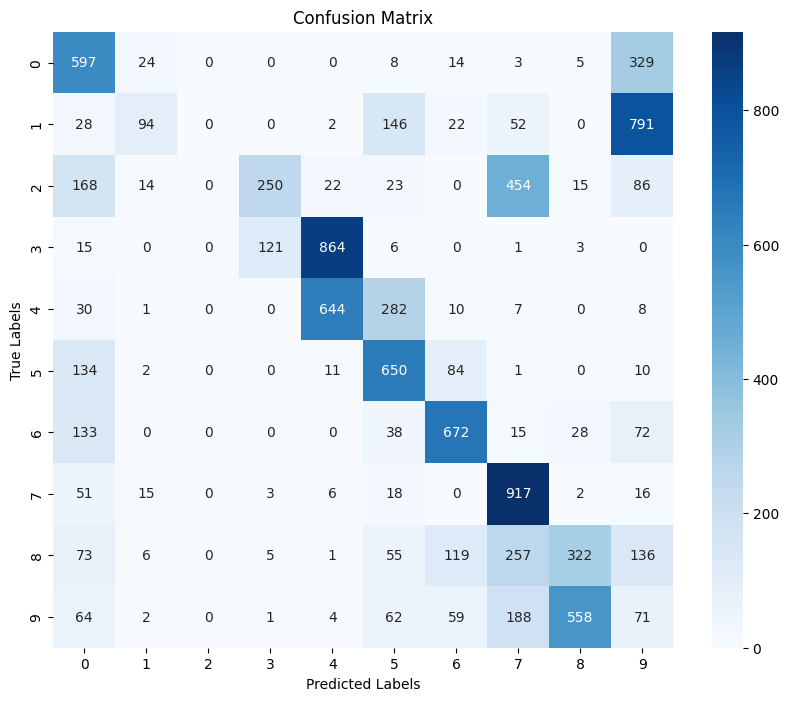

The zero-shot performance on MNIST is 40.84%, visual encoder is ViT-B/16.
The average testing loss is 1.8824.


In [11]:
prompt='0'

testing_loss = []
testing_acc = []

with torch.no_grad():
    model.eval()
    all_predictions = []
    all_labels = []
    
    for batch_idx, (images, labels) in enumerate(test_dataloader, start=1):
        images = images.to(device)
        labels = labels.to(device)
        
        text_inputs = prompt_encode(prompt)

        similarity = model_inference(model, images, text_inputs)
        
        criterion_CE = nn.CrossEntropyLoss()
        
        loss = criterion_CE(similarity, labels)
        testing_loss.append(loss.item())
        
        predictions = torch.argmax(similarity, dim=-1)
        acc = (predictions == labels).float().mean()
        testing_acc.append(acc.item())
        
        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}/{len(test_dataloader)}")
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())   

    val_loss = np.mean(testing_loss)
    val_acc = np.mean(testing_acc)
    
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(f"The zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")
print(f"The average testing loss is {val_loss:.4f}.")

Batch 10/79
Batch 20/79
Batch 30/79
Batch 40/79
Batch 50/79
Batch 60/79
Batch 70/79


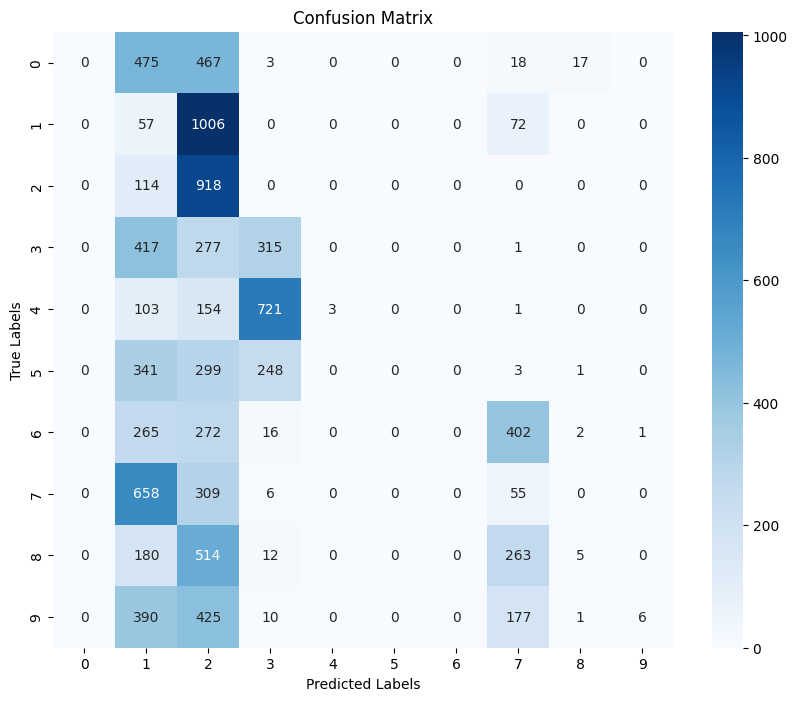

The zero-shot performance on MNIST is 13.65%, visual encoder is ViT-B/16.
The average testing loss is 2.2534.


In [12]:
prompt='3 5'

testing_loss = []
testing_acc = []

with torch.no_grad():
    model.eval()
    all_predictions = []
    all_labels = []
    
    for batch_idx, (images, labels) in enumerate(test_dataloader, start=1):
        images = images.to(device)
        labels = labels.to(device)
        
        text_inputs = prompt_encode(prompt)

        similarity = model_inference(model, images, text_inputs)
        
        criterion_CE = nn.CrossEntropyLoss()
        
        loss = criterion_CE(similarity, labels)
        testing_loss.append(loss.item())
        
        predictions = torch.argmax(similarity, dim=-1)
        acc = (predictions == labels).float().mean()
        testing_acc.append(acc.item())
        
        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}/{len(test_dataloader)}")
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())   

    val_loss = np.mean(testing_loss)
    val_acc = np.mean(testing_acc)
   
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(f"The zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")
print(f"The average testing loss is {val_loss:.4f}.")

Batch 10/79
Batch 20/79
Batch 30/79
Batch 40/79
Batch 50/79
Batch 60/79
Batch 70/79


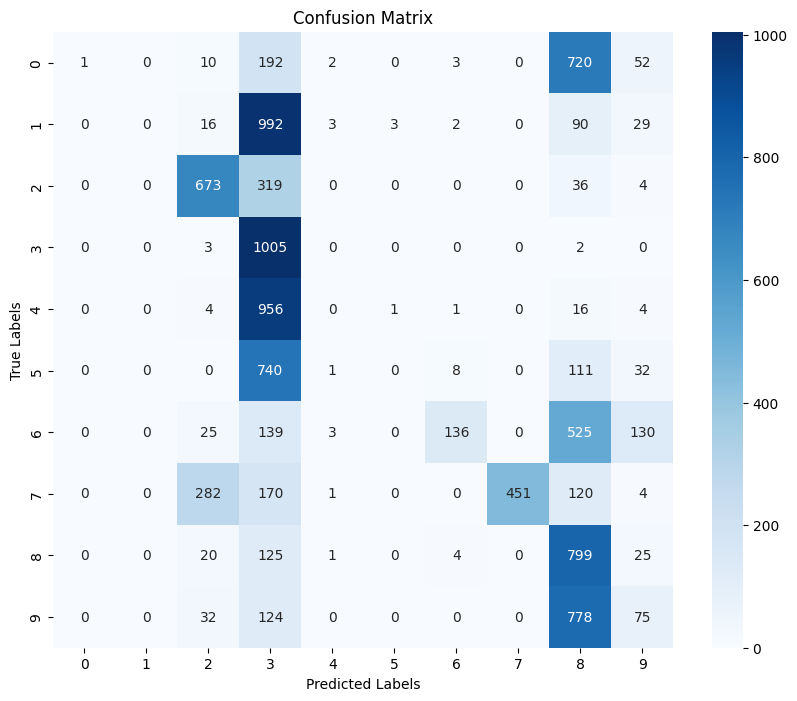

The zero-shot performance on MNIST is 31.40%, visual encoder is ViT-B/16.
The average testing loss is 2.1237.


In [13]:
prompt='5 3'

testing_loss = []
testing_acc = []

with torch.no_grad():
    model.eval()
    all_predictions = []
    all_labels = []
    
    for batch_idx, (images, labels) in enumerate(test_dataloader, start=1):
        images = images.to(device)
        labels = labels.to(device)
        
        text_inputs = prompt_encode(prompt)

        similarity = model_inference(model, images, text_inputs)
        
        criterion_CE = nn.CrossEntropyLoss()
        
        loss = criterion_CE(similarity, labels)
        testing_loss.append(loss.item())
        
        predictions = torch.argmax(similarity, dim=-1)
        acc = (predictions == labels).float().mean()
        testing_acc.append(acc.item())
        
        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}/{len(test_dataloader)}")
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())   

    val_loss = np.mean(testing_loss)
    val_acc = np.mean(testing_acc)
    
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(f"The zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")
print(f"The average testing loss is {val_loss:.4f}.")

Batch 10/79
Batch 20/79
Batch 30/79
Batch 40/79
Batch 50/79
Batch 60/79
Batch 70/79


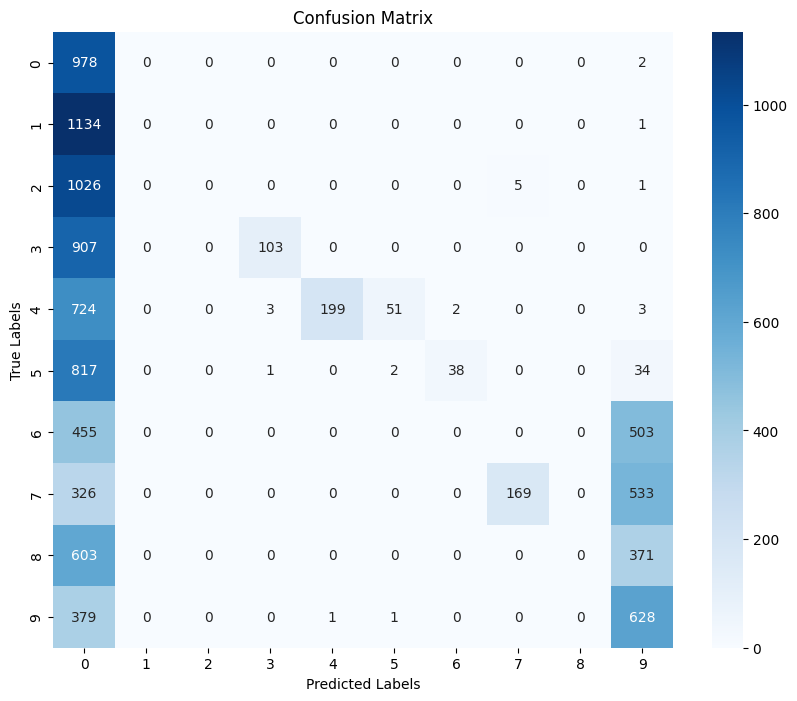

The zero-shot performance on MNIST is 20.70%, visual encoder is ViT-B/16.
The average testing loss is 2.1287.


In [14]:
prompt='a photo of a'

testing_loss = []
testing_acc = []

with torch.no_grad():
    model.eval()
    all_predictions = []
    all_labels = []
    
    for batch_idx, (images, labels) in enumerate(test_dataloader, start=1):
        images = images.to(device)
        labels = labels.to(device)
        
        text_inputs = prompt_encode(prompt)

        similarity = model_inference(model, images, text_inputs)
        
        criterion_CE = nn.CrossEntropyLoss()
        
        loss = criterion_CE(similarity, labels)
        testing_loss.append(loss.item())
        
        predictions = torch.argmax(similarity, dim=-1)
        acc = (predictions == labels).float().mean()
        testing_acc.append(acc.item())
        
        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}/{len(test_dataloader)}")
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())   

    val_loss = np.mean(testing_loss)
    val_acc = np.mean(testing_acc)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(f"The zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")
print(f"The average testing loss is {val_loss:.4f}.")

Batch 10/79
Batch 20/79
Batch 30/79
Batch 40/79
Batch 50/79
Batch 60/79
Batch 70/79


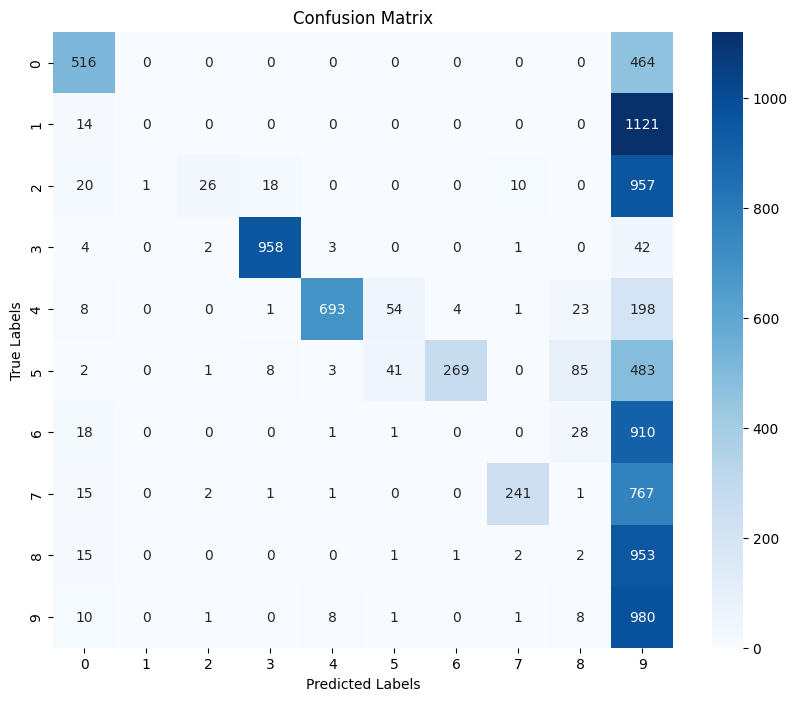

The zero-shot performance on MNIST is 34.53%, visual encoder is ViT-B/16.
The average testing loss is 1.7939.


In [15]:
prompt='not a photo of a'

testing_loss = []
testing_acc = []

with torch.no_grad():
    model.eval()
    all_predictions = []
    all_labels = []
    
    for batch_idx, (images, labels) in enumerate(test_dataloader, start=1):
        images = images.to(device)
        labels = labels.to(device)
        
        text_inputs = prompt_encode(prompt)

        similarity = model_inference(model, images, text_inputs)
        
        criterion_CE = nn.CrossEntropyLoss()
        
        loss = criterion_CE(similarity, labels)
        testing_loss.append(loss.item())
        
        predictions = torch.argmax(similarity, dim=-1)
        acc = (predictions == labels).float().mean()
        testing_acc.append(acc.item())
        
        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}/{len(test_dataloader)}")
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())   

    val_loss = np.mean(testing_loss)
    val_acc = np.mean(testing_acc)
    
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(f"The zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")
print(f"The average testing loss is {val_loss:.4f}.")

Batch 10/79
Batch 20/79
Batch 30/79
Batch 40/79
Batch 50/79
Batch 60/79
Batch 70/79


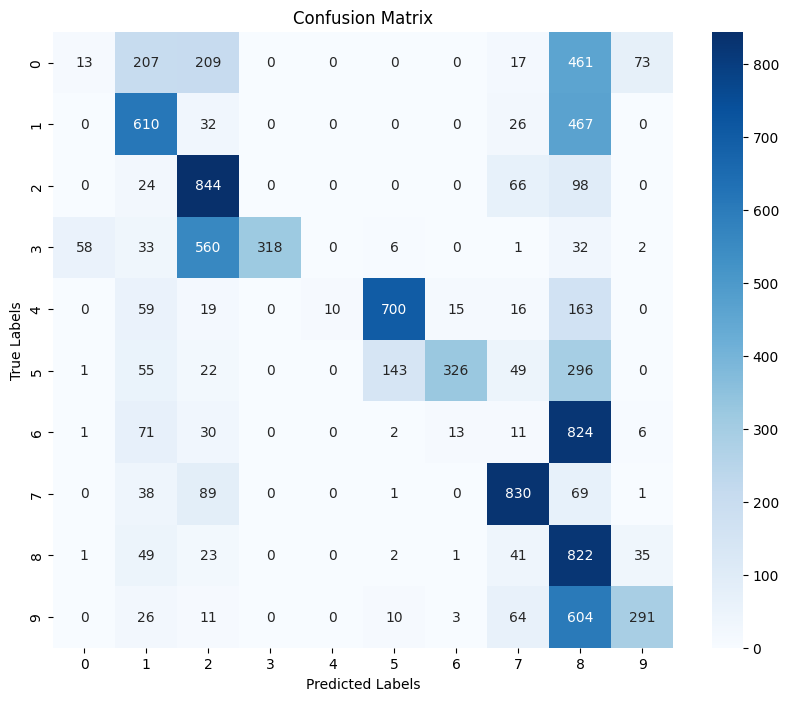

The zero-shot performance on MNIST is 38.92%, visual encoder is ViT-B/16.
The average testing loss is 1.8319.


In [16]:
prompt='apple'

testing_loss = []
testing_acc = []

with torch.no_grad():
    model.eval()
    all_predictions = []
    all_labels = []
    
    for batch_idx, (images, labels) in enumerate(test_dataloader, start=1):
        images = images.to(device)
        labels = labels.to(device)
        
        text_inputs = prompt_encode(prompt)

        similarity = model_inference(model, images, text_inputs)
        
        criterion_CE = nn.CrossEntropyLoss()
        
        loss = criterion_CE(similarity, labels)
        testing_loss.append(loss.item())
        
        predictions = torch.argmax(similarity, dim=-1)
        acc = (predictions == labels).float().mean()
        testing_acc.append(acc.item())
        
        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}/{len(test_dataloader)}")
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())   

    val_loss = np.mean(testing_loss)
    val_acc = np.mean(testing_acc)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(f"The zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")
print(f"The average testing loss is {val_loss:.4f}.")

Batch 10/79
Batch 20/79
Batch 30/79
Batch 40/79
Batch 50/79
Batch 60/79
Batch 70/79


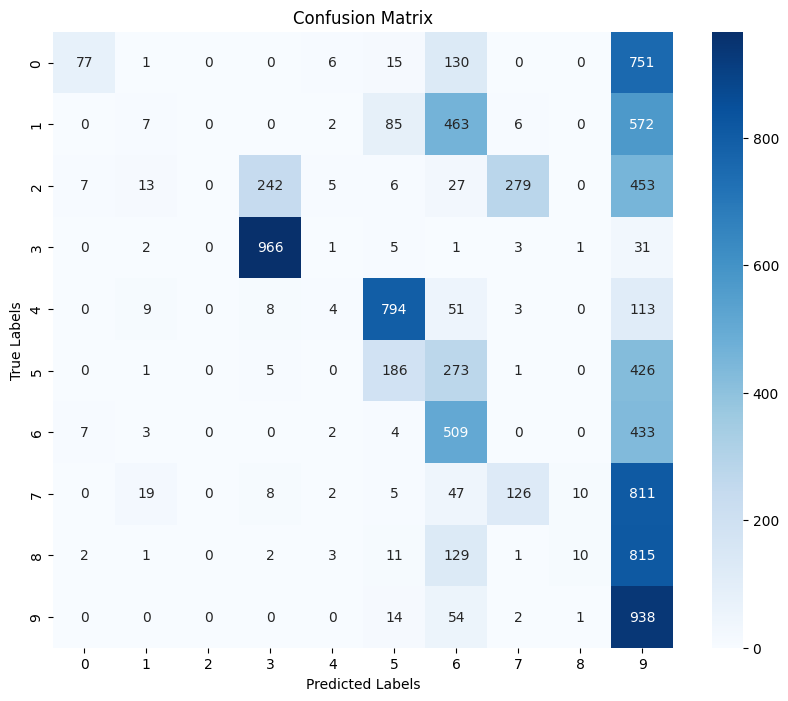

The zero-shot performance on MNIST is 28.26%, visual encoder is ViT-B/16.
The average testing loss is 1.9540.


In [17]:
prompt='bag'

testing_loss = []
testing_acc = []

with torch.no_grad():
    model.eval()
    all_predictions = []
    all_labels = []
    
    for batch_idx, (images, labels) in enumerate(test_dataloader, start=1):
        images = images.to(device)
        labels = labels.to(device)
        
        text_inputs = prompt_encode(prompt)

        similarity = model_inference(model, images, text_inputs)
        
        criterion_CE = nn.CrossEntropyLoss()
        
        loss = criterion_CE(similarity, labels)
        testing_loss.append(loss.item())
        
        predictions = torch.argmax(similarity, dim=-1)
        acc = (predictions == labels).float().mean()
        testing_acc.append(acc.item())
        
        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}/{len(test_dataloader)}")
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())   

    val_loss = np.mean(testing_loss)
    val_acc = np.mean(testing_acc)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(f"The zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")
print(f"The average testing loss is {val_loss:.4f}.")